In [1]:
from PIL import Image
import torch
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
import torchvision.transforms as transforms


In [2]:
def convert(input):
    image = (input / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
    image = Image.fromarray(image)
    return image

In [3]:
x = torch.zeros(1,3,512,512, dtype=torch.float64)
x = x + (0.1**0.5)*torch.randn(1,3,512,512)

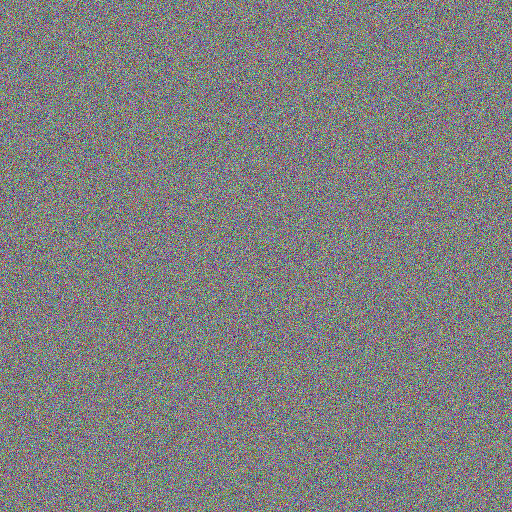

In [4]:
img=convert(x)
img

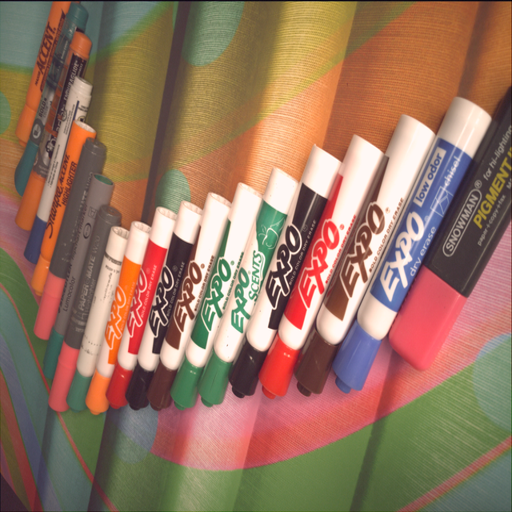

In [5]:
import requests
import torch
from PIL import Image
from io import BytesIO
url ="https://i.ibb.co/Pg0W4Tj/GT-SRGB-010.png"
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((512,512))
init_image

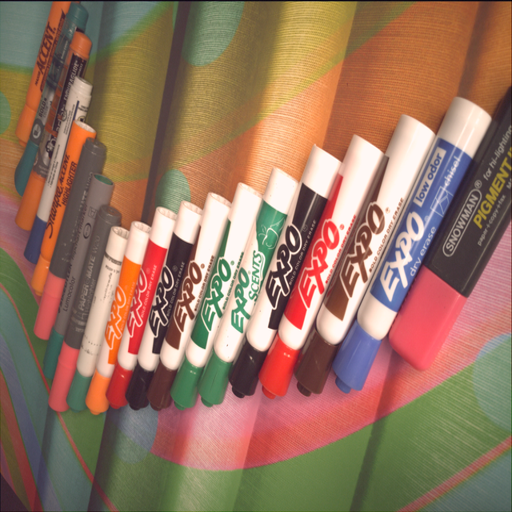

In [6]:
IN_ = Image.blend(img, init_image, alpha=1)
IN_

In [7]:
def help(pil_image):
    # Define a transformation to convert RGB PIL image to PyTorch tensor
    transform = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor(),
    ])

    # Convert RGB PIL image to PyTorch tensor
    image_tensor = transform(pil_image)

    # Ensure the tensor has 3 channels (RGB)
    if image_tensor.shape[0] != 3:
        raise ValueError("The input image is not an RGB image.")

    # Add a batch dimension
    image_tensor = image_tensor.unsqueeze(0)

    # Pad channels to create a tensor with shape (1, 4, 64, 64)
    padded_tensor = torch.cat([image_tensor, torch.zeros(1, 1,64,64)], dim=1)

    # Now, padded_tensor has the shape (1, 4, 64, 64)
    print(padded_tensor.shape)
    return padded_tensor


In [8]:
latentt=help(IN_)
latentt

torch.Size([1, 4, 64, 64])


tensor([[[[0.3529, 0.3686, 0.3765,  ..., 0.4235, 0.5098, 0.5451],
          [0.3922, 0.4118, 0.4275,  ..., 0.5059, 0.5961, 0.6314],
          [0.4000, 0.4196, 0.4275,  ..., 0.5412, 0.6275, 0.6431],
          ...,
          [0.2275, 0.2784, 0.3176,  ..., 0.3608, 0.3529, 0.3412],
          [0.2275, 0.2353, 0.2706,  ..., 0.3412, 0.3412, 0.3294],
          [0.2235, 0.2275, 0.2392,  ..., 0.3176, 0.3176, 0.3098]],

         [[0.4118, 0.4275, 0.4353,  ..., 0.2471, 0.2941, 0.3255],
          [0.4627, 0.4784, 0.4902,  ..., 0.2902, 0.3451, 0.3765],
          [0.4667, 0.4824, 0.4941,  ..., 0.3098, 0.3686, 0.3804],
          ...,
          [0.1451, 0.1765, 0.2353,  ..., 0.4235, 0.4196, 0.4118],
          [0.1451, 0.1529, 0.1961,  ..., 0.4039, 0.4039, 0.3961],
          [0.1412, 0.1451, 0.1569,  ..., 0.3804, 0.3804, 0.3725]],

         [[0.3804, 0.3961, 0.4039,  ..., 0.1804, 0.1765, 0.1765],
          [0.4196, 0.4353, 0.4471,  ..., 0.2000, 0.1961, 0.2000],
          [0.4235, 0.4431, 0.4510,  ..., 0

In [9]:
# latents=latentt
# latents.shape

In [10]:

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_safetensors=True)
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")


In [11]:
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="text_encoder", use_safetensors=True
)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder="unet", use_safetensors=True
)

In [12]:
from diffusers import UniPCMultistepScheduler

scheduler = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [13]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0): Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): LoRACompatibleConv(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): LoRACompatibleLinear(in_features=320, out_features=320, bias=False)
                (to_k): LoRACompatibleLinear(in_features=320, out_features=320, bias

In [14]:
# prompt = ["panda"]
prompt = ["chicago downtown skyscraper,4k,realistic,high definition,scenery"]
height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion
num_inference_steps = 60  # Number of denoising steps
guidance_scale = 10  # Scale for classifier-free guidance
generator = torch.manual_seed(9110)  # Seed generator to create the initial latent noise
batch_size = len(prompt)

In [15]:
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [16]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [17]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

In [18]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)

In [19]:
latents.shape

torch.Size([1, 4, 64, 64])

In [20]:
latents

tensor([[[[ 0.9089, -0.6502, -0.3802,  ...,  0.2652, -1.2167,  0.4022],
          [-1.0865, -0.6620, -1.0494,  ...,  0.5633, -0.1583, -1.5918],
          [ 0.1813,  2.7361, -1.0250,  ...,  0.6205,  1.4487,  1.2512],
          ...,
          [-0.0543,  1.6874, -1.2679,  ...,  3.7045,  0.2744,  0.4110],
          [-2.4844,  0.3071, -0.2655,  ...,  0.2891,  0.0450,  1.0661],
          [-0.1376, -0.3235,  1.7161,  ..., -2.2877, -1.2970, -2.0502]],

         [[-0.9249, -1.3788,  1.2477,  ..., -0.1059, -0.4246,  0.0724],
          [-0.2497,  0.1960, -0.8678,  ..., -1.7967, -1.4172, -0.1637],
          [ 1.6230, -0.8302,  0.4748,  ...,  0.7036, -0.2935,  0.3498],
          ...,
          [-0.7852, -1.5918,  1.1132,  ...,  0.3535,  0.4422,  1.9996],
          [-0.8072, -1.2649, -0.9074,  ..., -0.7610, -0.6211,  0.6166],
          [ 0.3955, -1.3510,  0.3531,  ...,  0.5180, -1.1155, -0.7894]],

         [[-0.2578,  0.5388, -0.1783,  ...,  0.6525, -1.4530, -0.7692],
          [-0.2372,  1.7439,  

In [21]:
latents = latents * scheduler.init_noise_sigma

In [22]:
from tqdm.auto import tqdm

scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/60 [00:00<?, ?it/s]

In [23]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

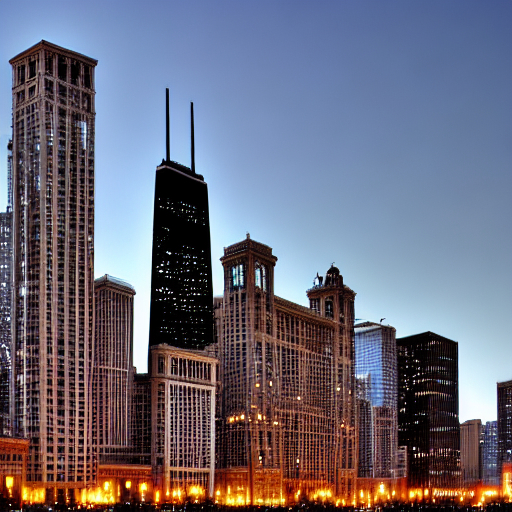

In [24]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
images = (image * 255).round().astype("uint8")
image = Image.fromarray(image)
image